# Feature Engineering

Building conversions from metric to imperial units, calculating slopes, and rolling averages.

In [ ]:
import os, sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

# Add utils/ to path
cwd = Path.cwd()
for base in (cwd, cwd.parent, cwd.parent.parent):
    if (base / "utils").exists():
        sys.path.insert(0, str(base))
        break

from utils.fit import fit_to_df, parse_fit_file
from config import DATA_PATH

routes_path = DATA_PATH

In [2]:
activity_file_name = sorted(
    [f for f in os.listdir(routes_path) if f.endswith('.fit')]
)[0]
print(f"Parsing {activity_file_name}")

raw_df = fit_to_df(os.path.join(routes_path, activity_file_name))
raw_df.head()

Parsing 2025-06-30-15-07-06.fit


,accumulated_power,activity_type,cadence,distance,enhanced_altitude,enhanced_speed,fractional_cadence,heart_rate,position_lat,position_long,...,unknown_107,unknown_134,unknown_135,unknown_136,unknown_137,unknown_138,unknown_140,unknown_143,unknown_87,unknown_90
0,106,running,48,1.99,54.0,1.318,0.5,101,457455223,-1455557466,...,0,None,64,101,100,100,1292,13,0.0,NaN
1,198,running,48,3.91,54.0,1.318,0.5,100,457455161,-1455557734,...,1,None,67,100,100,100,1292,13,0.0,NaN
2,317,running,48,6.13,53.8,1.318,0.5,100,457455054,-1455558061,...,1,None,67,100,100,100,1292,13,NaN,NaN
3,467,running,48,8.69,53.6,1.318,0.5,100,457454958,-1455558381,...,1,None,67,100,100,100,1292,13,0.0,NaN
4,616,running,48,11.54,53.6,1.802,0.5,100,457454792,-1455558667,...,1,None,67,100,100,100,1767,13,0.0,NaN


In [3]:
df = parse_fit_file(
    os.path.join(routes_path, activity_file_name),
    metric=False
)

interest_cols = [
    'timestamp', 'elapsed_time_s',
    'distance_mi', 'speed_mph',
    'heart_rate',
    'altitude_ft', 'vert_change_ft', 'cum_vert_gain_ft',
    'gradient', 'gradient_percent', 'gradient_deg',
    'cadence', 'step_length_ft', 'power', 'accumulated_power',
    'temperature_f'
]
df = df[interest_cols].copy()
df.head()

,timestamp,elapsed_time_s,distance_mi,speed_mph,heart_rate,altitude_ft,vert_change_ft,cum_vert_gain_ft,gradient,gradient_percent,gradient_deg,cadence,step_length_ft,power,accumulated_power,temperature_f
0,2025-06-30 22:07:06,0.0,0.001237,2.948287,101,177.165360,0.000000,0.0,0.000000,0.000000,0.000000,48.5,2.696850,106,106,93.2
1,2025-06-30 22:07:07,1.0,0.002430,2.948287,100,177.165360,0.000000,0.0,0.000000,0.000000,0.000000,48.5,2.696850,92,198,93.2
2,2025-06-30 22:07:08,2.0,0.003809,2.948287,100,176.509192,-0.656168,0.0,-0.090090,-9.009009,-5.147885,48.5,2.696850,119,317,93.2
3,2025-06-30 22:07:09,3.0,0.005400,2.948287,100,175.853024,-0.656168,0.0,-0.078125,-7.812500,-4.467159,48.5,3.690945,150,467,93.2
4,2025-06-30 22:07:10,4.0,0.007171,4.030966,100,175.853024,0.000000,0.0,0.000000,0.000000,0.000000,48.5,4.340551,149,616,93.2


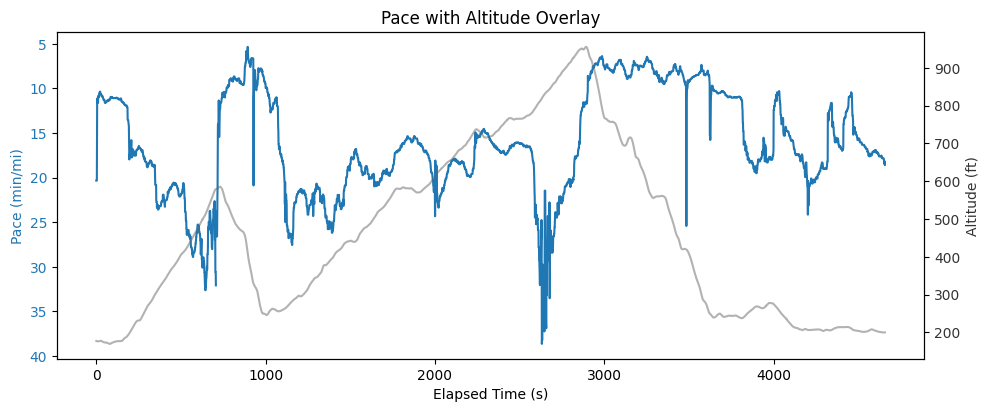

In [4]:
# Pace over time with altitude overlay (secondary axis)
required = {'speed_mph', 'elapsed_time_s', 'altitude_ft'}

if required.issubset(set(df.columns)):
    pace_min_per_mi = 60.0 / df['speed_mph'].replace(0, np.nan)
    fig, ax1 = plt.subplots(figsize=(10, 4))
    ax1.plot(df['elapsed_time_s'], pace_min_per_mi, color='tab:blue', label='Pace (min/mi)')
    ax1.set_xlabel('Elapsed Time (s)')
    ax1.set_ylabel('Pace (min/mi)', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.invert_yaxis()  # faster up

    ax2 = ax1.twinx()
    alt_sm = df['altitude_ft'].rolling(15, min_periods=1).mean()
    ax2.plot(df['elapsed_time_s'], alt_sm, color='0.4', alpha=0.5, label='Altitude (ft)')
    ax2.set_ylabel('Altitude (ft)', color='0.2')
    ax2.tick_params(axis='y', labelcolor='0.2')
    ax2.grid(False)

    fig.tight_layout()
    plt.title('Pace with Altitude Overlay')
    plt.show()
else:
    print('Required columns not found for pace/altitude overlay.')


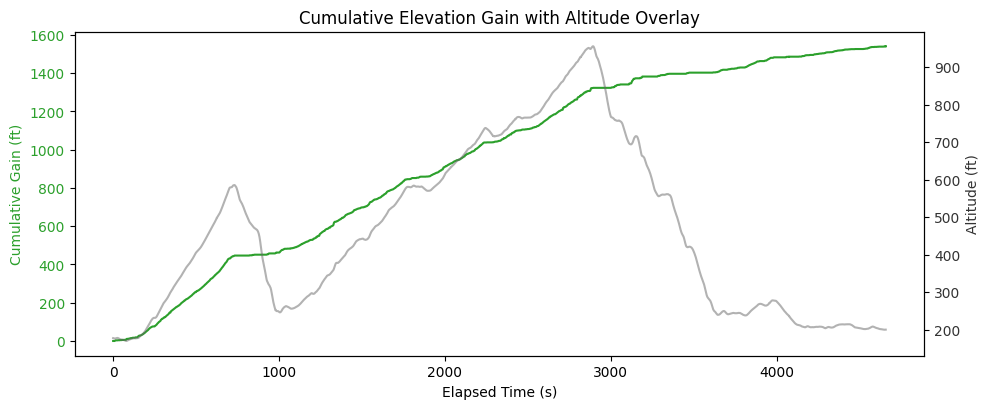

In [5]:
# Cumulative elevation gain over time with altitude overlay
required = {'cum_vert_gain_ft', 'elapsed_time_s', 'altitude_ft'}

if required.issubset(set(df.columns)):
    fig, ax1 = plt.subplots(figsize=(10, 4))
    ax1.plot(df['elapsed_time_s'], df['cum_vert_gain_ft'], color='tab:green', label='Cumulative Gain (ft)')
    ax1.set_xlabel('Elapsed Time (s)')
    ax1.set_ylabel('Cumulative Gain (ft)', color='tab:green')
    ax1.tick_params(axis='y', labelcolor='tab:green')

    ax2 = ax1.twinx()
    alt_sm = df['altitude_ft'].rolling(15, min_periods=1).mean()
    ax2.plot(df['elapsed_time_s'], alt_sm, color='0.4', alpha=0.5, label='Altitude (ft)')
    ax2.set_ylabel('Altitude (ft)', color='0.2')
    ax2.tick_params(axis='y', labelcolor='0.2')
    ax2.grid(False)

    fig.tight_layout()
    plt.title('Cumulative Elevation Gain with Altitude Overlay')
    plt.show()
else:
    print('Required columns not found for cumulative gain/altitude overlay.')
